In [35]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, ParameterGrid, cross_val_predict, cross_val_score, cross_validate
import matplotlib.pyplot as plt
import xgboost as xgb

In [36]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

In [37]:
X_train = X_train.drop(['Unnamed: 0'], axis = 1)
X_test = X_test.drop(['Unnamed: 0'], axis = 1)
y_train = y_train.drop(['Unnamed: 0'], axis = 1)
y_test = y_test.drop(['Unnamed: 0'], axis = 1)

In [38]:
X_train_trivial = X_train[X_train.budget == 0]
X_test_trivial = X_test[X_test.budget == 0]

X_train_nontrivial = X_train[X_train.budget != 0]
X_test_nontrivial = X_test[X_test.budget != 0]

train_indeces = X_train_nontrivial.index
test_indeces = X_test_nontrivial.index

y_train_nontrivial = y_train.iloc[train_indeces]
y_test_nontrivial = y_test.iloc[test_indeces]

In [39]:
parameters = {'max_depth':[4,5,6,7,8,9,10,11,12],
              'n_estimators':range(100,7000,200), 
              'learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2,0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.9], 
              'subsample':[0.1,0.2,0.3,0.4,0.5,0.6, 0.7, 0.8, 0.9,1.0], 
              'reg_lambda':[0,1,2,3,4,5,6,7,8,9,10], 
              'gamma':[0,1,2,3,4,5,6,7,8,9,10]}
model = RandomizedSearchCV(xgb.XGBClassifier(random_state=45), param_distributions = parameters, n_iter = 200, 
                           n_jobs=-1, verbose=1, cv=5, scoring=['accuracy','recall'], refit="recall")
model.fit(X_train_nontrivial, y_train_nontrivial)
print (model.best_score_, model.best_params_) 

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
0.9938456797439847 {'subsample': 1.0, 'reg_lambda': 10, 'n_estimators': 1100, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 9}


In [44]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_le = le.fit_transform(y_train_nontrivial)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [45]:
model_class = xgb.XGBClassifier(random_state=45, max_depth = 6 , n_estimators = 1100, 
                                  learning_rate = 0.01, subsample = 1, reg_lambda = 10, gamma = 9)
nontrivial_ypred = cross_val_predict(model_class, X_train_nontrivial.values, y_train_le, cv = 5, method = 'predict_proba')

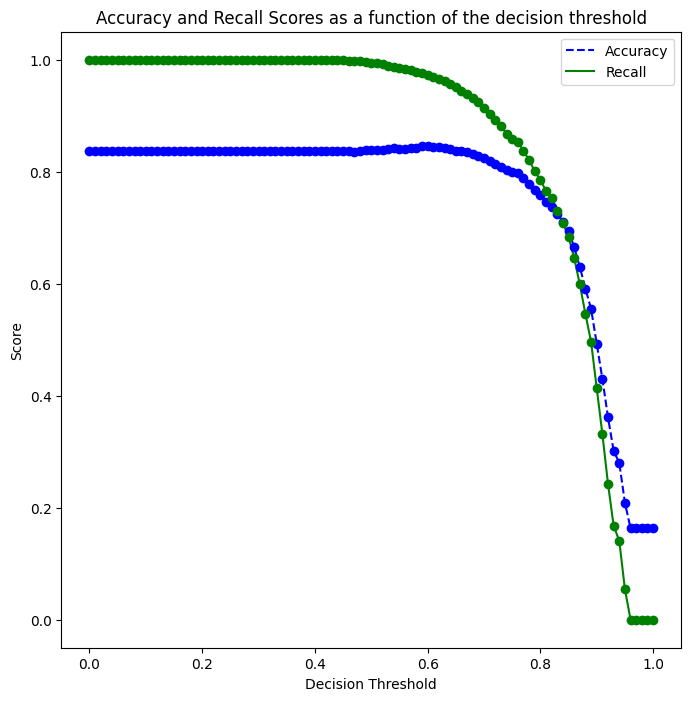

In [47]:

accuracies = []
recalls = []

thresholds = np.arange(0,1.01,0.01)
for threshold in thresholds:
    predicted_class = nontrivial_ypred[:,1] > threshold
    predicted_class = predicted_class.astype(int)
    accuracy = accuracy_score(y_train_nontrivial, predicted_class)
    accuracies.append(accuracy)
    recall = recall_score(y_train_nontrivial, predicted_class)
    recalls.append(recall)


def plot_accuracy_recall_vs_threshold(accuracies, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Accuracy and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracies, "b--", label="Accuracy")
    plt.plot(thresholds, recalls, "g-", label="Recall")
    plt.plot(thresholds, accuracies, "o", color = 'blue')
    plt.plot(thresholds, recalls, "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(accuracies, recalls, thresholds)

In [62]:
np.column_stack([thresholds,accuracies,recalls])

array([[0.        , 0.83672418, 1.        ],
       [0.01      , 0.83672418, 1.        ],
       [0.02      , 0.83672418, 1.        ],
       [0.03      , 0.83672418, 1.        ],
       [0.04      , 0.83672418, 1.        ],
       [0.05      , 0.83672418, 1.        ],
       [0.06      , 0.83672418, 1.        ],
       [0.07      , 0.83672418, 1.        ],
       [0.08      , 0.83672418, 1.        ],
       [0.09      , 0.83672418, 1.        ],
       [0.1       , 0.83672418, 1.        ],
       [0.11      , 0.83672418, 1.        ],
       [0.12      , 0.83672418, 1.        ],
       [0.13      , 0.83672418, 1.        ],
       [0.14      , 0.83672418, 1.        ],
       [0.15      , 0.83672418, 1.        ],
       [0.16      , 0.83672418, 1.        ],
       [0.17      , 0.83672418, 1.        ],
       [0.18      , 0.83672418, 1.        ],
       [0.19      , 0.83672418, 1.        ],
       [0.2       , 0.83672418, 1.        ],
       [0.21      , 0.83672418, 1.        ],
       [0.

In [48]:
#train
model_xg = model_class.fit(X_train_nontrivial, y_train_nontrivial)

In [63]:
predicted_probability = model_xg.predict_proba(X_train_nontrivial)[:,1]

optimal_threshold = 0.6

predicted_class = predicted_probability > optimal_threshold
predicted_class = predicted_class.astype(int)

    #Computing the accuracy
ac = accuracy_score(y_train_nontrivial, predicted_class)*100
rs = recall_score(y_train_nontrivial, predicted_class)*100
   

print('Nontrivial Train accuracy: ', ac)
print('Nontrivial Train Recall: ', rs)

Nontrivial Train accuracy:  85.06309554468194
Nontrivial Train Recall:  97.26069559864574


In [64]:

predicted_probability = model_xg.predict_proba(X_test_nontrivial)[:,1]

predicted_class = predicted_probability > optimal_threshold
predicted_class = predicted_class.astype(int)

#Computing the accuracy and recall
ac = accuracy_score(y_test_nontrivial,predicted_class)*100
rs = recall_score(y_test_nontrivial, predicted_class)*100

print('Nontrivial Test accuracy: ', ac)
print('Nontrivial Test Recall: ', rs)

Nontrivial Test accuracy:  85.6923076923077
Nontrivial Test Recall:  98.02158273381295


In [65]:
predicted_probability = model_xg.predict_proba(X_train_nontrivial)[:,1]
predicted_class = predicted_probability > optimal_threshold
nontrivial_pred = predicted_class.astype(int)

test_nontrivial_indeces = X_train_nontrivial.index
total_test_indeces = X_train.index
X_train_xg = X_train.copy()
X_train_xg['pred'] = [0]*10002

X_train_xg['pred'][test_nontrivial_indeces] = nontrivial_pred

ac = accuracy_score(y_train,X_train_xg.pred)*100
rs = recall_score(y_train, X_train_xg.pred)*100

print('Total train accuracy: ', ac)
print('Total train Recall: ', rs)

Total train accuracy:  76.61467706458708
Total train Recall:  63.09904153354633


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [66]:
predicted_probability = model_xg.predict_proba(X_test_nontrivial)[:,1]
predicted_class = predicted_probability > optimal_threshold
nontrivial_pred = predicted_class.astype(int)

test_nontrivial_indeces = X_test_nontrivial.index
total_test_indeces = X_test.index
X_test_xg = X_test.copy()
X_test_xg['pred'] = [0]*1766

X_test_xg['pred'][test_nontrivial_indeces] = nontrivial_pred

ac = accuracy_score(y_test,X_test_xg.pred)*100
rs = recall_score(y_test, X_test_xg.pred)*100

print('Total Test accuracy: ', ac)
print('Total Test Recall: ', rs)

Total Test accuracy:  76.61381653454133
Total Test Recall:  62.21461187214612


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [58]:
booster = model_xg.get_booster()
importances_xg = booster.get_score()
importances = pd.DataFrame.from_dict(data=importances_xg, 
                                       orient='index')

importances.sort_values(0, ascending = False)

,0
runtime,375.0
budget,288.0
belongs_to_collection,231.0
production_countries_US,138.0
tagline,136.0
production_countries_IN,97.0
homepage,93.0
genres_Horror,22.0
genres_Comedy,5.0


In [68]:
parameters = {'max_depth':[4,5,6,7,8,9,10,11,12],
              'n_estimators':range(100,7000,200), 
              'learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2,0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.9], 
              'subsample':[0.1,0.2,0.3,0.4,0.5,0.6, 0.7, 0.8, 0.9,1.0], 
              'reg_lambda':[0,1,2,3,4,5,6,7,8,9,10], 
              'gamma':[0,1,2,3,4,5,6,7,8,9,10]}
model = RandomizedSearchCV(xgb.XGBClassifier(random_state=45), param_distributions = parameters, n_iter = 200, 
                           n_jobs=-1, verbose=1, cv=5, scoring=['accuracy','recall'], refit="recall")
model.fit(X_train, y_train)
print (model.best_score_, model.best_params_) 

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.7522014911236468 {'subsample': 0.6, 'reg_lambda': 8, 'n_estimators': 1100, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0}


In [69]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_le_total = le.fit_transform(y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [90]:
model_class = xgb.XGBClassifier(random_state=45, max_depth = 8 , n_estimators = 1100, 
                                  learning_rate = 0.01, subsample = 0.6, reg_lambda = 8, gamma = 0)
cross_val_ypred = cross_val_predict(model_class, X_train.values, y_train_le_total, cv = 5, method = 'predict_proba')

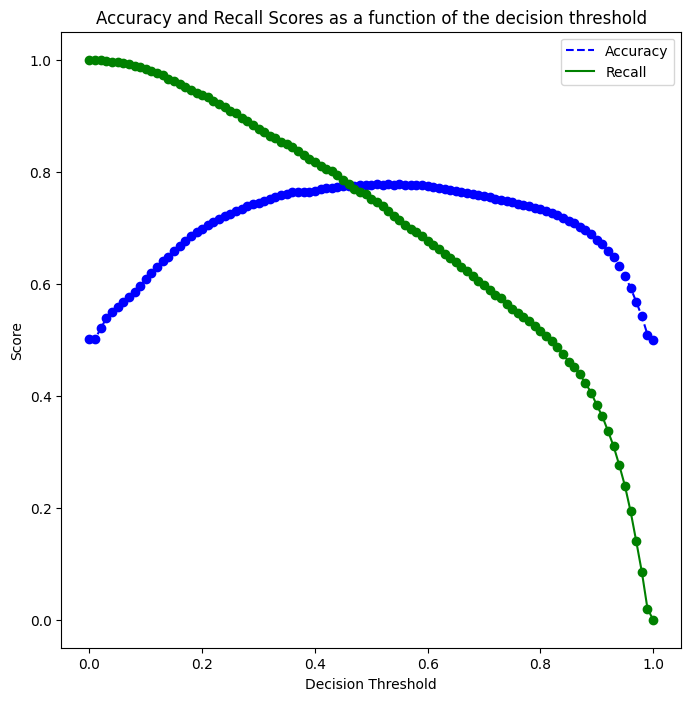

In [91]:

accuracies = []
recalls = []

thresholds = np.arange(0,1.01,0.01)
for threshold in thresholds:
    predicted_class = cross_val_ypred[:,1] > threshold
    predicted_class = predicted_class.astype(int)
    accuracy = accuracy_score(y_train, predicted_class)
    accuracies.append(accuracy)
    recall = recall_score(y_train, predicted_class)
    recalls.append(recall)


def plot_accuracy_recall_vs_threshold(accuracies, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Accuracy and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracies, "b--", label="Accuracy")
    plt.plot(thresholds, recalls, "g-", label="Recall")
    plt.plot(thresholds, accuracies, "o", color = 'blue')
    plt.plot(thresholds, recalls, "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(accuracies, recalls, thresholds)

In [92]:
np.column_stack([thresholds,accuracies,recalls])

array([[0.        , 0.50069986, 1.        ],
       [0.01      , 0.50119976, 1.        ],
       [0.02      , 0.52019596, 0.99880192],
       [0.03      , 0.53839232, 0.99780351],
       [0.04      , 0.54999   , 0.99640575],
       [0.05      , 0.55878824, 0.99540735],
       [0.06      , 0.5674865 , 0.9938099 ],
       [0.07      , 0.57588482, 0.99201278],
       [0.08      , 0.58588282, 0.98881789],
       [0.09      , 0.59608078, 0.98642173],
       [0.1       , 0.60817836, 0.98282748],
       [0.11      , 0.6194761 , 0.97983227],
       [0.12      , 0.63007399, 0.97563898],
       [0.13      , 0.64027195, 0.97304313],
       [0.14      , 0.64857029, 0.96645367],
       [0.15      , 0.65826835, 0.96166134],
       [0.16      , 0.66656669, 0.95607029],
       [0.17      , 0.67556489, 0.95127796],
       [0.18      , 0.68466307, 0.94508786],
       [0.19      , 0.69196161, 0.94129393],
       [0.2       , 0.69736053, 0.93769968],
       [0.21      , 0.70555889, 0.93290735],
       [0.

In [93]:
#train
model_xg = model_class.fit(X_train, y_train)

In [94]:
predicted_probability = model_xg.predict_proba(X_train)[:,1]

optimal_threshold = 0.46

predicted_class = predicted_probability > optimal_threshold
predicted_class = predicted_class.astype(int)

    #Computing the accuracy
ac = accuracy_score(y_train, predicted_class)*100
rs = recall_score(y_train, predicted_class)*100
   

print('Nontrivial Train accuracy: ', ac)
print('Nontrivial Train Recall: ', rs)

Nontrivial Train accuracy:  83.04339132173565
Nontrivial Train Recall:  83.04712460063898


In [95]:
predicted_probability = model_xg.predict_proba(X_test)[:,1]

predicted_class = predicted_probability > optimal_threshold
predicted_class = predicted_class.astype(int)

#Computing the accuracy and recall
ac = accuracy_score(y_test,predicted_class)*100
rs = recall_score(y_test, predicted_class)*100

print('Nontrivial Test accuracy: ', ac)
print('Nontrivial Test Recall: ', rs)

Nontrivial Test accuracy:  78.14269535673839
Nontrivial Test Recall:  77.3972602739726


In [96]:
booster = model_xg.get_booster()
importances_xg = booster.get_score()
importances = pd.DataFrame.from_dict(data=importances_xg, 
                                       orient='index')

importances.sort_values(0, ascending = False)

,0
runtime,32239.0
release_month,17903.0
budget,16013.0
production_countries_US,3875.0
homepage,3509.0
genres_Comedy,3113.0
spoken_languages_en,3099.0
tagline,3010.0
belongs_to_collection,2829.0
genres_Drama,2696.0
